# Tutorial: Dynamic Lines

This tutorial will introduce an example of considering dynamic lines in `LITS`.
Note that this tutorial is for `LITS 0.3.5`. Future versions will have dedicated functions to find an equilibrium point using a Power Flow method without relying in a guess of the initial condition to run a non-linear solver.

This tutorial presents a simulation of a three-bus system, with an infinite bus (represented as a voltage source behind an impedance) at bus 1, and a one d- one q- machine on bus 2 and an inverter of 19 states, as a virtual synchronous machine at bus 3. The perturbation will be the trip of two of the three circuits (triplicating its resistance and impedance) of the line that connects bus 1 and bus 3. This case also consider a dynamic line model for connection between buses 2 and 3.

It is recommended to check `Tutorial 1: OMIB` first, since that includes more details and explanations on all definitions and functions.

## Step 1: Package Initialization

Loading packages may take some time:

In [1]:
using LITS
using PowerSystems
using Sundials
using NLsolve
using Plots

┌ Info: Precompiling LITS [86b0dc02-7903-11e9-325f-f195ca7e6c1a]
└ @ Base loading.jl:1260


## Step 2: Data creation

To start we will define the data structures for the network.

### Buses and Branches

In [2]:
sys_file_dir= joinpath(dirname(@__FILE__), "Data","ThreeBusNetwork.raw")
sys = System(PowerModelsData(sys_file_dir), runchecks=false)

┌ Info: The PSS(R)E parser currently supports buses, loads, shunts, generators, branches, transformers, and dc lines
└ @ PowerSystems /Users/jdlara/.julia/packages/PowerSystems/y1jmI/src/parsers/pm_io/common.jl:26
┌ Info: the voltage setpoint on generator 1 does not match the value at bus 2
└ @ PowerSystems /Users/jdlara/.julia/packages/PowerSystems/y1jmI/src/parsers/pm_io/data.jl:1686
┌ Info: the voltage setpoint on generator 2 does not match the value at bus 3
└ @ PowerSystems /Users/jdlara/.julia/packages/PowerSystems/y1jmI/src/parsers/pm_io/data.jl:1686
┌ Info: Constructing System from Power Models
│   data["name"] = threebusnetwork
│   data["source_type"] = pti
└ @ PowerSystems /Users/jdlara/.julia/packages/PowerSystems/y1jmI/src/parsers/power_models_data.jl:39
┌ Info: Reading bus data
└ @ PowerSystems /Users/jdlara/.julia/packages/PowerSystems/y1jmI/src/parsers/power_models_data.jl:140
┌ Info: Reading generator data
└ @ PowerSystems /Users/jdlara/.julia/packages/PowerSystems/y1jm

,ConcreteType,SuperTypes,Count
,String,String,Int64
1,Area,AggregationTopology <: Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
2,Bus,Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,3
3,Line,ACBranch <: Branch <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,3
4,LoadZone,AggregationTopology <: Topology <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,1
5,PowerLoad,StaticLoad <: ElectricLoad <: StaticInjection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,3
6,ThermalStandard,ThermalGen <: Generator <: StaticInjection <: Device <: Component <: PowerSystemType <: InfrastructureSystemsType <: Any,2


### Injection devices

In [3]:
# get_components is designed to return fast Julia iterators. For this application we need to run collect to retrieve 
# the bus
slack_bus = collect(get_components(Bus, sys, b -> b.bustype == BusTypes.REF))[1]
inf_source = Source(
    name = "InfBus", #name
    available = true, #availability
    activepower = 0.0,
    reactivepower = 0.0,
    bus = slack_bus, #bus
    X_th = 0.000005 #Xth
) 
add_component!(sys, inf_source)

In [4]:
res = solve_powerflow!(sys, nlsolve)

┌ Info: Results of Nonlinear Solver Algorithm
│  * Algorithm: Trust-region with dogleg and autoscaling
│  * Starting Point: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
│  * Zero: [0.20124067386701996, 0.3105196276130643, -0.2385257550140026, 0.02539646703075343, -0.31530394561038, 0.013397451323691639]
│  * Inf-norm of residuals: 0.000000
│  * Iterations: 2
│  * Convergence: true
│    * |x - x'| < 0.0e+00: false
│    * |f(x)| < 1.0e-08: true
│  * Function Calls (f): 3
│  * Jacobian Calls (df/dx): 3
└ @ PowerSystems /Users/jdlara/.julia/packages/PowerSystems/y1jmI/src/utils/power_flow/power_flow.jl:145
┌ Info: PowerFlow solve converged, the results have been stored in the system
└ @ PowerSystems /Users/jdlara/.julia/packages/PowerSystems/y1jmI/src/utils/power_flow/power_flow.jl:148


true

### Dynamic injection devices

First we define our generator data:

In [5]:
function dyn_gen(generator)
    return DynamicGenerator(
        number = 1,
        name = "$(get_name(generator))",
        bus = get_bus(generator), #bus
        ω_ref = 1.0, 
        V_ref = 1.0, 
        P_ref = get_activepower(generator), 
        Q_ref = get_reactivepower(generator), 
        machine = OneDOneQMachine(
                0.0, #R
                1.3125, #Xd
                1.2578, #Xq
                0.1813, #Xd_p
                0.25, #Xq_p
                5.89, #Td0_p
                0.6, #Tq0_p
                100.0, #MVABase
            ),   
        shaft =  SingleMass(
                            3.01, #H (M = 6.02 -> H = M/2)
                            0.0, #D
                                ), 
        avr = AVRTypeI(
                        20.0, #Ka - Gain
                        0.01, #Ke
                        0.063, #Kf
                        0.2, #Ta
                        0.314, #Te
                        0.35, #Tf
                        0.001, #Tr
                        5.0, #Vrmax
                        -5.0, #Vrmin
                        0.0039, #Ae - 1st ceiling coefficient
                        1.555, #Be - 2nd ceiling coefficient
                    ), 
       prime_mover = TGFixed(1.0),
       pss = PSSFixed(0.0)
    ) 
end
generator = get_component(ThermalStandard, sys, "generator-2-1")
dyn_generator = dyn_gen(generator)
add_component!(sys, dyn_generator)

and for the inverter:

In [6]:
function inv_DAIB(generator)
    return DynamicInverter(
        number = 1,
        name = "VSM",
        bus = get_bus(generator),
        ω_ref = 1.0,
        V_ref = get_voltage(get_bus(generator)),
        P_ref = get_activepower(generator),
        Q_ref = get_reactivepower(generator),
        MVABase = 2.75,
        converter = AverageConverter(
                                138.0, #Rated Voltage
                                100.0, #Rated MVA
                                 ),
        outer_control = OuterControl(
                        VirtualInertia(
                                        2.0, #Ta:: VSM inertia constant
                                        400.0, #kd:: VSM damping coefficient
                                        20.0, #kω:: Frequency droop gain in pu
                                        2 * pi * 50.0, #ωb:: Rated angular frequency
                                       ), 
                        ReactivePowerDroop(
                                        0.2, #kq:: Reactive power droop gain in pu
                                        1000.0, #ωf:: Reactive power cut-off low pass filter frequency
                                        )
                                            ),
        inner_control = CurrentControl(
                                        0.59, #kpv:: Voltage controller proportional gain
                                        736.0, #kiv:: Voltage controller integral gain
                                        0.0, #kffv:: Binary variable enabling the voltage feed-forward in output of current controllers
                                        0.0, #rv:: Virtual resistance in pu
                                        0.2, #lv: Virtual inductance in pu
                                        1.27, #kpc:: Current controller proportional gain
                                        14.3, #kiv:: Current controller integral gain
                                        0.0, #kffi:: Binary variable enabling the current feed-forward in output of current controllers
                                        50.0, #ωad:: Active damping low pass filter cut-off frequency
                                        0.2, #kad:: Active damping gain
                                    ), 
        dc_source = FixedDCSource(1500.0),
        freq_estimator = KauraPLL(
                            500.0, #ω_lp: Cut-off frequency for LowPass filter of PLL filter.
                            0.084, #k_p: PLL proportional gain
                            4.69, #k_i: PLL integral gain
                        ),
        filter = LCLFilter(
                0.08, #Series inductance lf in pu
                0.003, #Series resitance rf in pu
                0.074, #Shunt capacitance cf in pu
                0.2, #Series reactance rg to grid connection (#Step up transformer or similar)
                0.01, #Series resistance lg to grid connection (#Step up transformer or similar)
            )
    )
end
generator = get_component(ThermalStandard, sys, "generator-3-2")
dyn_inverter = inv_DAIB(generator)
add_component!(sys, dyn_inverter)

In [7]:
dynamic_branch = get_component(Line, sys, "3")
make_dynamic_branch!(dynamic_branch, sys)

In [8]:
#Compute Y_bus after fault
fault_branches = deepcopy(collect(get_components(Line, sys))[1:end])
faulted_line = [br for br in fault_branches if br.name == "1"][1]
# Increase impedance of line (equivalent to a circuit trip)
faulted_line.r = 0.03 ; faulted_line.x = 0.36; faulted_line.b = (from = 0.03, to = 0.03)
Ybus_fault = Ybus(fault_branches, get_components(Bus, sys))[:, :]
#Construct the perturbation
perturbation_Ybus = ThreePhaseFault(
    1.0, #change will occur at t = 1.0s
    Ybus_fault, #new Ybus
)

ThreePhaseFault(1.0, 
  [1, 1]  =  0.695095-8.17495im
  [3, 1]  =  -0.695095+8.27495im
  [2, 2]  =  0.229885-2.72862im
  [3, 2]  =  -0.229885+2.75862im
  [1, 3]  =  -0.695095+8.27495im
  [2, 3]  =  -0.229885+2.75862im
  [3, 3]  =  0.92498-10.9036im)

## Step 3: Build the simulation and initializing the problem

First, we construct the perturbation, by properly computing the new Ybus:

Now, we check the indexing:

In [9]:
#Time span of our simulation
tspan = (0.0, 30.0)

#Define Simulation
sim = Simulation(
    sys, #system
    tspan, #time span
    perturbation_Ybus, #Type of perturbation
    initialize_simulation = false #keyword argument to not find initial conditions.
)

Simulation()


This is a clear example on which a flat start is not enough to properly initialize the system, so we provide a guess:

In [10]:
x0_guess = [1.00, #V1_R
          1.00, #V2_R
          1.00, #V3_R
          0.0, #V1_I
         -0.01, #V2_I
         -0.01, #V3_I
         0.0, #δω_vsm
          0.2, #δθ_vsm
          0.025, #qm
          0.0015, #ξ_d
          -0.07, #ξ_q
          0.05, #γ_d
        -0.001, #γ_q
         0.95, #ϕ_d
         -0.10, #ϕ_q
         1.004, #vpll_d
         0.0, #vpll_q
         0.0, #ε_pll
         0.1, #δθ_pll
         0.5, #id_cv
         0.0, #iq_cv
         0.95, #vod
         -0.1, #voq
         0.49, #iod
        -0.1, #ioq
          1.0, #eq_p
          0.47, #ed_p
          0.6, #δ
          1.0, #ω
          2.1, #Vf
          0.28, #Vr1
          -0.39, #Vr2,
          1.0, #Vm
          0.5, #IL1_R
          0.5] #IL1_I

sim = Simulation(
    sys, #system
    tspan, #time span
    perturbation_Ybus, #Type of perturbation
    initial_guess = x0_guess #initial guess.
)

┌ Info: Initializing Simulation States
└ @ LITS /Users/jdlara/.julia/dev/LITS/src/base/simulation.jl:32


Simulation()


## Step 4: Run the simulation

In [11]:
run_simulation!(sim, #simulation structure
                IDA()) #Sundials DAE Solver

## Step 5: Explore the solution

In [12]:
volt = get_voltagemag_series(sim, 2)
plot(volt, xlabel="time", ylabel="Voltage [pu]", label="V_2")

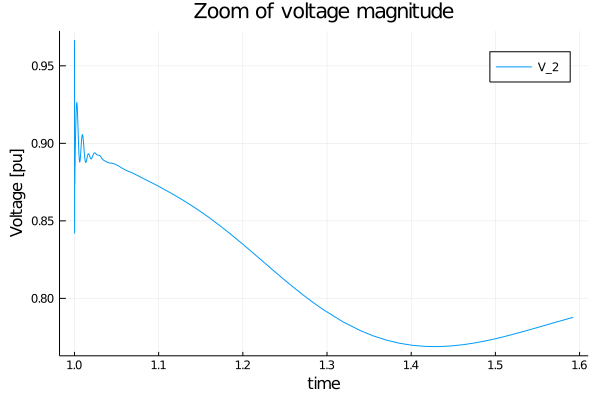

In [13]:
zoom = [(volt[1][ix], volt[2][ix]) for (ix, s) in enumerate(volt[1]) if (s > 0.90 && s < 1.6)]
plot(zoom, xlabel="time", ylabel="Voltage [pu]", title="Zoom of voltage magnitude", label="V_2")